In [120]:
import torch
import torch.nn as nn  # All neural network modules, nn.Linear, nn.Conv2d, BatchNorm, Loss functions
import torchvision.transforms as transforms  # Transformations we can perform on our dataset
import torchvision
import os
from skimage import io
from torch.utils.data import Dataset,DataLoader
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import random
from PIL import Image,ImageOps
from sklearn.model_selection import train_test_split
import time
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from torch.nn import LeakyReLU,ReLU,Tanh,Sigmoid,Softmax
import torch.nn.functional as F
from sklearn.metrics import mean_squared_error, mean_absolute_error,balanced_accuracy_score,brier_score_loss,cohen_kappa_score
from sklearn.metrics import classification_report,accuracy_score,roc_auc_score,precision_recall_curve,confusion_matrix,precision_score,confusion_matrix,roc_auc_score,precision_score
from torch import optim
from tqdm.notebook import tqdm
from tqdm import trange
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

## Preview

(1024, 1024)


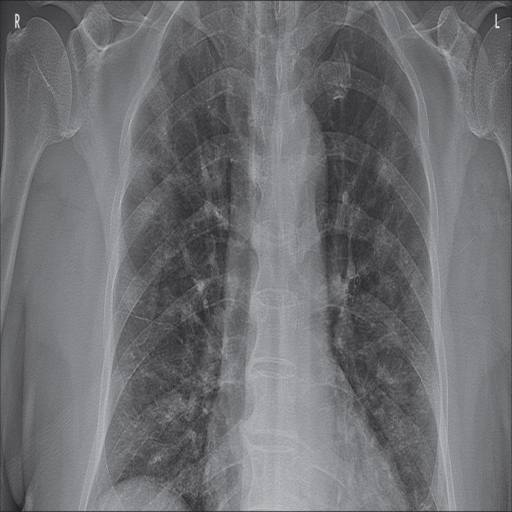

In [121]:
print(Image.open('data/COVID-19 (1).png').size)
transforms.Resize(size = (512,512))(Image.open('data/COVID-19 (1).png'))

### Seed Everything

In [122]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(69)

### Custom Image Loading Class

In [137]:
df

,Name,Labels
0,COVID-19 (1).png,1
1,COVID-19 (2).png,1
2,COVID-19 (3).png,1
3,COVID-19 (4).png,1
4,COVID-19 (5).png,1
...,...,...
2900,Viral Pneumonia (1341).png,2
2901,Viral Pneumonia (1342).png,2
2902,Viral Pneumonia (1343).png,2
2903,Viral Pneumonia (1344).png,2


In [123]:
class ImageData(Dataset):
    def __init__(self,df,data_dir,transform=None):
        self.df = df
        self.data_dir = data_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self,index):
        img_path = os.path.join(self.data_dir,self.df.iloc[index,0])
        labels = torch.tensor(self.df.iloc[index,1:],dtype=torch.long)
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform is not None:
            image = self.transform(image = image)["image"] #----------------------> Difference
        return (image,labels)

https://www.kaggle.com/yukia18/opencv-vs-pil-speed-comparisons-for-pytorch-user

### Model

In [124]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=5, stride=1, padding=2)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(125440, 3) 
        
    def forward(self, x):
        out = self.cnn1(x)
        out = self.relu1(out)
        out = self.maxpool1(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        
        return out

### Accuracy Calculation *

In [125]:
ba = 0.935
vacc=[]
tacc=[]
def accuracy(Train_DL,Validation_DL):
    ta = 0
    for x,y in Train_DL:
        ta += accuracy_score((y),(F.softmax(m(x),dim=1).argmax(axis=1)).detach())
    ta = round(ta/6,3) # Divide by number of runs per epoch (Depends on batch_size)
    tacc.append(ta)
    for xv,yv in Validation_DL:
            va = round(accuracy_score((yv),(F.softmax(m(xv),dim=1).argmax(axis=1)).detach()),3)
            global ba
            if va > ba:
                ba = va
                torch.save(m.state_dict(),'Good Looking Model 1')
    vacc.append(round(va,3))
    return ta,va,tacc,vacc

### Training Loop

In [126]:
def trainloop(model,runs,Train_DL,Validation_DL):
    lt = []
    start = time.process_time()
    for epoch in range(runs):
        for X, Y in Train_DL:
            Y_pred = model(X)
            J = loss(Y_pred,(Y).squeeze())
            J.backward()
            optimizer.step()
            optimizer.zero_grad()
        lt.append(J.item())
        ta,va,tacc,vacc = accuracy(Train_DL,Validation_DL)
        print(f'Epoch {epoch+1} / {runs}: Training Loss={J:.2f} | Training Accuracy={ta} | Validation Accuracy={va}')
#         flag = 0
#         if epoch >= 3:
#             flag = early_stop(vacc)
#         if flag==1:
#             print('======================================================')
#             print('Early Stopping Initiated')
#             break
#         scheduler.step()
    print('======================================================')
    print('Wall Time:',time.process_time() - start)
    return lt,tacc,vacc

### Early Stopping

In [127]:
ind = 0
def early_stop(vacc):
    global ind
    if(vacc[-1]-vacc[-2]<=0.001):
        ind += 1
    else:
        ind = 0
    return (1 if ind>=2 else 0)

### Plotting Curves

In [128]:
def acc_plots(loss,tacc,vacc):
    e = [i+1 for i in range(len(tacc))]
    df1 = pd.DataFrame({'Epoch':e,'Loss':loss,'Train Accuracy':tacc,'Validation Accuracy':vacc})
    plt.figure(figsize=(15,6))
    plt.subplot(1,2,1)
    sns.lineplot(data=df1,x='Epoch',y='Loss').set(title='Train Loss Trend')
    plt.subplot(1,2,2)
    sns.lineplot(data=df1,x='Epoch',y='Train Accuracy',label='Train')
    sns.lineplot(data=df1,x='Epoch',y='Validation Accuracy',label='Validation').set(title='Accuracy Comparison', ylabel='Accuracy');
    plt.legend()
    plt.show;

### Classification Report

In [129]:
def report(Validation_DL):
    for X_v,Y_v in Validation_DL:
        pred1 = F.softmax(m(X_v),dim=1)
        pred2 = (pred1.argmax(axis=1))
        print("===========================================================")
        print('                        TEST REPORT')
        print("===========================================================")
        print("Accuracy           ",accuracy_score((Y_v),pred2.detach()))
        print("ROC AUC            ",roc_auc_score((Y_v).squeeze(),pred1.detach(),multi_class='ovo'))
        print("-----------------------------------------------------------")
        cm=confusion_matrix((Y_v),pred2)
        print("Confusion Matrix  \n",cm)
        print("-----------------------------------------------------------")
        print("Classification Report \n",classification_report((Y_v),pred2))
        print("-----------------------------------------------------------")
        print("MSE ",mean_squared_error((Y_v),pred2))

### Wrap & Run

In [130]:
def Wrap(model,epochs,Train_DL,Validation_DL):
    loss,tacc,vacc = trainloop(model,epochs,Train_DL,Validation_DL)
    acc_plots(loss,tacc,vacc)
    report(Validation_DL)
    print('===================================================')
    print('Done Training!')
    print('===================================================')

In [131]:
m = CNNModel()
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(m.parameters(), lr=0.01)
# scheduler  = torch.optim.lr_scheduler.StepLR(optimizer, 25, gamma=0.001, last_epoch=-1)

In [132]:
df = pd.read_csv('Some Meta.csv')
train,val = train_test_split(df,test_size=0.1,stratify=df.Labels,random_state=69)

## Things to keep in mind:

1. Training data augmentation should probably involve random rescaling, horizontal flips, perturbations to brightness, contrast, and color, as well as random cropping.
2. Test-time augmentation should probably involve both a mixture of multiple rescaling of each image as well as predictions for multiple different systematic crops of each rescaled version of the image.
3. You should validate only on the original images. The augmentation is there so that it can help your model generalize better, but to evaluate your model you need actual images, not transformed ones.

Your training pipeline could be something like this:


          +-> training set ---> data augmentation --+
          |                                         |
          |                                         +-> model training --+
          |                                         |                    |
       all data -+-> validation set ----------------+                    |
          |                                                              +-> model testing
          |                                                              |
          |                                                              |
          +-> test set --------------------------------------------------+

### Recommended Augmentations:

Full Blog: https://nanonets.com/blog/data-augmentation-how-to-use-deep-learning-when-you-have-limited-data-part-2/

Depending on your data these are the augmentations you must perform:
1. Flip
2. Rotation
3. Scale
4. Crop
5. Translation
6. Gaussian Noise

### Torchvision

In [133]:
train_transform_tv = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224, 224)),
    torchvision.transforms.RandomHorizontalFlip(p=0.75),
    torchvision.transforms.RandomRotation(10),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform_tv = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

### Albumentations

#### Migrating from torchvision to albumentations is simple - you just need to change a few lines of code. Albumentations has equivalents for common torchvision transforms as well as plenty of transforms that are not presented in torchvision. 

This notebook explains the same:

https://github.com/albumentations-team/albumentations_examples/blob/master/notebooks/migrating_from_torchvision_to_albumentations.ipynb



| torchvision transform 	| albumentations transform 	| albumentations example 	|
|---------------------------------------------------------------------------------------------------------------------------------	|---------------------------------------------------------------------------------------------------------------------------------------------------------	|---------------------------------------------------------------------------------------------	|
| [Compose](https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision.transforms.Compose) 	| [Compose](https://albumentations.readthedocs.io/en/latest/api/core.html#albumentations.core.composition.Compose) 	| ```Compose([Resize(256, 256), RandomCrop(224, 224)])``` 	|
| [CenterCrop](https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision.transforms.CenterCrop) 	| [CenterCrop](https://albumentations.readthedocs.io/en/latest/api/augmentations.html#albumentations.augmentations.transforms.CenterCrop) 	| ```CenterCrop(256, 256)``` 	|
| [ColorJitter](https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision.transforms.ColorJitter) 	| [HueSaturationValue](https://albumentations.readthedocs.io/en/latest/api/augmentations.html#albumentations.augmentations.transforms.HueSaturationValue) 	| ```HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5)``` 	|
| [Pad](https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision.transforms.Pad) 	| [PadIfNeeded](https://albumentations.readthedocs.io/en/latest/api/augmentations.html#albumentations.augmentations.transforms.PadIfNeeded) 	| ```PadIfNeeded(min_height=512, min_width=512)``` 	|
| [RandomAffine](https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision.transforms.RandomAffine) 	| [ShiftScaleRotate](https://albumentations.readthedocs.io/en/latest/api/augmentations.html#albumentations.augmentations.transforms.ShiftScaleRotate) 	| ```ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=45, p=0.5)``` 	|
| [RandomCrop](https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision.transforms.RandomCrop) 	| [RandomCrop](https://albumentations.readthedocs.io/en/latest/api/augmentations.html#albumentations.augmentations.transforms.RandomCrop) 	| ```RandomCrop(256, 256)``` 	|
| [RandomGrayscale](https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision.transforms.RandomGrayscale) 	| [ToGray](https://albumentations.readthedocs.io/en/latest/api/augmentations.html#albumentations.augmentations.transforms.ToGray) 	| ```ToGray(p=0.5)``` 	|
| [RandomHorizontalFlip](https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision.transforms.RandomHorizontalFlip) 	| [HorizontalFlip](https://albumentations.readthedocs.io/en/latest/api/augmentations.html#albumentations.augmentations.transforms.HorizontalFlip) 	| ```HorizontalFlip(p=0.5)``` 	|
| [RandomRotation](https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision.transforms.RandomRotation) 	| [Rotate](https://albumentations.readthedocs.io/en/latest/api/augmentations.html#albumentations.augmentations.transforms.Rotate) 	| ```Rotate(limit=45, p=0.5)``` 	|
| [RandomVerticalFlip](https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision.transforms.RandomVerticalFlip) 	| [VerticalFlip](https://albumentations.readthedocs.io/en/latest/api/augmentations.html#albumentations.augmentations.transforms.VerticalFlip) 	| ```VerticalFlip(p=0.5)``` 	|
| [Resize](https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision.transforms.Resize) 	| [Resize](https://albumentations.readthedocs.io/en/latest/api/augmentations.html#albumentations.augmentations.transforms.Resize) 	| ```Resize(256, 256)``` 	|
| [Normalize](https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision.transforms.Normalize) 	| [Normalize](https://albumentations.readthedocs.io/en/latest/api/augmentations.html#albumentations.augmentations.transforms.Normalize) 	| ```Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])``` 	|

In [134]:
train_transform_alb = A.Compose(
    [
        A.SmallestMaxSize(max_size=1024),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.RandomCrop(height=224, width=224),
        A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)

val_transform_alb = A.Compose(
    [
        A.SmallestMaxSize(max_size=1024),
        A.CenterCrop(height=224, width=224),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)

In [135]:
training_generator = DataLoader(ImageData(train,data_dir='data',transform=train_transform_alb),batch_size = 512,shuffle = True)
validation_generator = DataLoader(ImageData(val,data_dir='data',transform=val_transform_alb),batch_size = 512,shuffle = True)

### Let's Begin!

Epoch 1 / 5: Training Loss=80.22 | Training Accuracy=0.471 | Validation Accuracy=0.464
Epoch 2 / 5: Training Loss=235.06 | Training Accuracy=0.396 | Validation Accuracy=0.46
Epoch 3 / 5: Training Loss=40.62 | Training Accuracy=0.437 | Validation Accuracy=0.46
Epoch 4 / 5: Training Loss=61.08 | Training Accuracy=0.354 | Validation Accuracy=0.485
Epoch 5 / 5: Training Loss=29.44 | Training Accuracy=0.517 | Validation Accuracy=0.543
Wall Time: 3154.828125
                        TEST REPORT
Accuracy            0.5429553264604811
ROC AUC             0.5367434711962075
-----------------------------------------------------------
Confusion Matrix  
 [[ 51   1  82]
 [ 14   1   7]
 [ 27   2 106]]
-----------------------------------------------------------
Classification Report 
               precision    recall  f1-score   support

           0       0.55      0.38      0.45       134
           1       0.25      0.05      0.08        22
           2       0.54      0.79      0.64       135

 

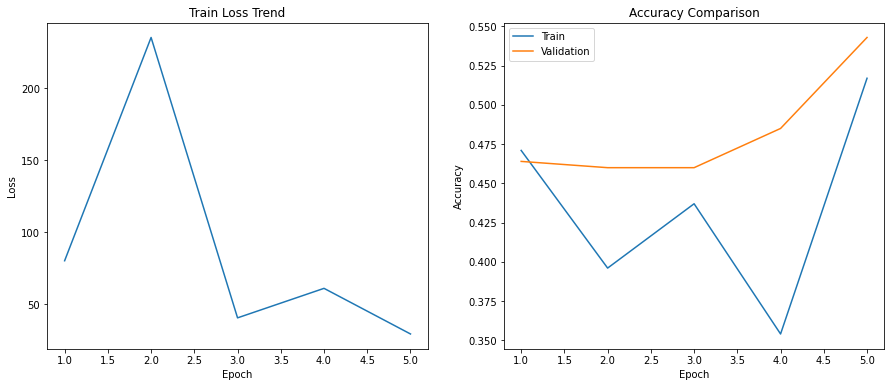

In [136]:
epochs = 5
Wrap(m,epochs,training_generator,validation_generator)